# New Approach: CUP

Imagine a plot with utility of the true positive (uTP) on the x-axis, from 0 to 1. On the y-axis, we’d have H/B with a reasonable logarithmic range. Since we established a way to translate Cfp/Cfn into H/B, we can get the optimal point on the ROC. For each pair of uTP and H/B, we can find the optimal point on the ROC that maximizes expected utility. That point gives us the pair of sensitivity and specificity. We use it to find the expected utility as well as pL and pU, the lower and upper priors between which the model has value. This would give us 3 plots. First plot shows the expected value; second plot shows the lowest prior for which the model has value; the third plot shows the highest prior for which the model has value.

Let's call the approach **clinical utility profiling (CUP)**
- credit to ChatGPT for brainstorming
- FHIR profiling -> defining the standard of a resource and its requirement. 
- We are defining the reporting standards of a machine learning model
    - performance (AUC, sensitivity, specificity, all the other good stuff)
    - we should also report clinical utility/usefulness, which better supports decision making
    - to support decision making, we need 
        - prior probability, preferences, utility, and alignment with model development
    - CUP
        - profile a model's clinical utility/performance based on
            - utility (uTP)
            - maxNNT or model tradeoff (H/B)
            - applicable range of prior probability of the target population 
        - procedure
            - train a model and get the ROC curve
            - for each pair of uTP and H/B
                - find the optimal point using the formula
                    - slope = H/B * 1 / Odds (is this fitted ROC (current) or polygonal ROC or range of ideal points)
                - find the expected utility (EU) for that point on the ROC and the prior probability of disease
                - find the lower prior threshold (pL) and the upper prior threshold (pU)
                - save EU, pL, pU for each pair of uTP and H/B
            - graph 3 plots
    - 3 plots
        - For all plots
            - x-axis varies over ranges of uTP (utility of a true positive)
            - y-axis varies over ranges of H/B tradeoff (reflecting the model's misclassification cost) 
                - or maximum number needed to treat (which then ties clinical semantics to model development)
        - 3 plots
            - first plot graphs the EU
                - interpretation is: for each pair of utility and model tradeoff, what is the max EU
            - the second plot graphs the lower prior
                - interpretation is: for each pair of utility and model tradeoff, what is the lower prior threshold
            - the third plot graphs the upper prior 
                - interpretation is: for each pair of utility and model tradeoff, what is the upper prior threshold
- pros:
    - based on decision theory
    - assessment of model performance over different preferences and model tradeoff
        - more holistic model evaluation that includes assessment of utility
    - computationally easy (O()) on the order of?
    - tackles the problem of quantifying preferences
    - relates clinical semantics to model development and assessment (coherence and alignment)
- cons:
    - 3 graphs instead of 1
        - I'd argue it's the right thing to do
    - assuming a single point of ideal use?
        - get a bunch of model in use comparing their, what is the implied cost tradeoff in use?
        - 

Statistical Plan
- write up functions to do this calculation
- generate such set of plots for one test model 
- visualize and see if reduction is possible

In [1]:
import numpy as np
import sympy as sy
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import time # timestamp

In [79]:
def treatAll(x, uFP, uTP):
    """
    Expected value calculation for the option treat all
    
    Args: 
        x (float): probability
        uFP (float): utility of false positive
        uTP (float): utility of true positive
        
    Returns: 
        expected utility (float)
    
    """
    return x * uTP + (1-x) * uFP

def treatNone(x, uFN, uTN):
    """
    Expected value calculation for the option treat none
    
    Args: 
        x (float): probability
        uFN (float): utility of false negative
        uTN (float): utility of true negative
        
    Returns: 
        expected utility (float)
    
    """
    return x * uFN + (1-x) * uTN

def test(x, sensitivity, specificity, uTN, uTP, uFN, uFP, u):
    """
    Expected value calculation for the option test
    
    Args: 
        x (float): probability
        sensitivity (float): sensitivity of the test
        specificity (float): specificity of the test
        uTN (float): utility of true negative = 1
        uTP (float): utility of true positive, cost of false negative (misclassifying a minority class) 
                        is the cost of not getting the benefit of TP
        uFN (float): utility of false negative = 0, the cost of not getting the benefit of TP is uTP
        uFP (float): utility of false positive, harm = 1-uFP = cost of FP
        u: utility of the test itself
        
    Returns: 
        expected utility (float)
    
    """
    
    return x * sensitivity * uTP + x * (1-sensitivity) * uFN + (1-x) * (1-specificity) * uFP + (1-x) * specificity * uTN + u

def pLpUThresholds(sens, spec, uTN, uTP, uFN, uFP, u):
    """
    Identifies the lower and upper thresholds formed by the three utility lines
    
    Args: 
        sens (float): sensitivity of the test
        spec (float): specificity of the test
        uTN (float): utility of true negative
        uTP (float): utility of true positive
        uFN (float): utility of false negative
        uFP (float): utility of false positive
        u: utility of the test itself
        
    Returns: 
        a list of two thresholds (pL and pU): [pL, pU]
    
    """
    #initate a variable called x (prior)
    x = sy.symbols('x')
    
#     print(u)
    
    #solve for upper threshold formed by test and treat all
    pU = sy.solve(treatAll(x, uFP, uTP) - test(x, sens, spec, uTN, uTP, uFN, uFP, u), x)
    
    #solve for lower threshold formed by treat none and test
    pL = sy.solve(treatNone(x, uFN, uTN) - test(x, sens, spec, uTN, uTP, uFN, uFP, u), x)
    
    #placeholder values when there are not two thresholds formed
    pU = -1 if (len(pU) == 0) else float(pU[0])
    pU = 1 if (pU > 1) else pU
    pU = 0 if ((pU < 0) & (pU != -999)) else pU
    pL = -1 if (len(pL) == 0) else float(pL[0])
    pL = 1 if (pL > 1) else pL
    pL = 0 if ((pL < 0) & (pL != -999)) else pL

    return [pL, pU]



def optimalPointOnRoc(false_positive_rate, sensitivity, prob_cutoffs, desired_slope, n_int = 1000):
    """
    Find the optimal point on the ROC curve that maximizes patient utility
    
    Args: 
        false_positive_rate (array): fprs of the test
        sensitivity (array): tprs of the test
        desired_slope (float): slope of interest
        
    Returns: 
        the point on the ROC curve with the specified curve
    
    """
    # slope of interest
#     desired_slope = maxNNT * (1 - pDisease) / pDisease
    
    # Generate a finer grid for FPR to interpolate TPR (sensitivity) values
    fpr_fine = np.linspace(false_positive_rate.min(), false_positive_rate.max(), n_int)
    tpr_fine = np.interp(fpr_fine, false_positive_rate, sensitivity)

    # Calculate the slope between consecutive points on the interpolated curve
    slopes_fine = np.gradient(tpr_fine, fpr_fine)

    # Find the index of the point with the slope closest to the desired_slope
    closest_slope_index = np.argmin(np.abs(slopes_fine - desired_slope))
    closest_slope = slopes_fine[closest_slope_index]

    # Corresponding FPR and TPR values for the closest slope
    closest_fpr = fpr_fine[closest_slope_index]
    closest_tpr = tpr_fine[closest_slope_index]
    
    # Corresponding probability cutoff
    closest_prob_cutoff = prob_cutoffs[closest_slope_index]

    return closest_slope, closest_fpr, closest_tpr, closest_prob_cutoff


def minicup(pDisease, fprs, tprs, prob_cutoffs, costRatio, utilities):
    """
    Clinical Utility Profiling subcomponent
    - for one pair of uTP and H/B
        - calculate maxEU, pL, and pU
    
    Args:
        pDisease (float): probability of disease
        fprs (array): fprs of the test
        tprs (array): tprs of the test
        costRatio (float): 1/costRatio = maxNNT
            maxNNT: H/B tradeoff; ratio of misclassification costs Cfp/Cfn; 1/costratio = H/B; cmc_major/cmc_minor
        utilities (array): array carrying uTP and dU (disutility of testing itself)
        
    Returns:
        an array of maxEU, pL, pU, uTP, maxNNT (H/B)
        
    
    """
    uTP, dU = utilities #uTP and disutility of testing itself
    uTN = 1.0
    uFN = 0
    HoverB = (1 / costRatio)
    uFP = uTN - (uTP - uFN) * HoverB
    
    # slope of interest
    desired_slope = HoverB * (1 - pDisease) / pDisease
    print(f'Desired slope is: {np.round(desired_slope, 3)}, given pDisease: {np.round(pDisease, 3)} and maxNNT: {np.round(HoverB, 3)}')
    
    #find the optimal point on the ROC and its associated specs
    closest_slope, closest_fpr, closest_tpr, closest_prob_cutoff = optimalPointOnRoc(fprs, tprs, prob_cutoffs, desired_slope)
    print(f'Closest slope is: {np.round(closest_slope, 3)}, corresponding to fpr: {np.round(closest_fpr, 3)} and tpr: {np.round(closest_tpr, 3)}')
    
    #find the expected utility for the given probability of disease in the target population, the sens and spec associated with the optimal point on the roc
    maxEU = test(pDisease, closest_tpr, 1-closest_fpr, uTN, uTP, uFN, uFP, dU)
    
    #pL and pU
    pL, pU = pLpUThresholds(closest_tpr, 1-closest_fpr, uTN, uTP, uFN, uFP, dU)
    print(pL)
    print(pU)
    print(closest_tpr)
    print(closest_fpr)

    return maxEU, pL, pU, closest_prob_cutoff, uTP, HoverB

def cup(pDisease, fprs, tprs, prob_cutoffs, costRatios, uTPs, dU):
    """
    Clinical Utility Profiling main
    - for each pair of uTP and H/B
        - calculate maxEU, pL, and pU
    - call minicup()
    
    Args:
        pDisease (float): probability of disease
        fprs (array): fprs of the test
        tprs (array): tprs of the test
        costRatio (float): 1/costRatio = maxNNT
            maxNNT: H/B tradeoff; ratio of misclassification costs Cfp/Cfn; 1/costratio = H/B; cmc_major/cmc_minor
        utilities (array): array carrying uTP and dU (disutility of testing itself)
        
    Returns:
        an array of maxEU, pL, pU, uTP, maxNNT (H/B)
        
    
    """
    
    #placeholders
    maxEUs = []
    pLs = []
    pUs = []
    prob_cutoffs = []
#     uTPs = []
#     maxNNTs = []
    
    start = time.time()
    for uTP in uTPs:
        print(uTP)
        for costRatio in costRatios: 
            print(f'Ratio between misclassifying a fn and a fp is: {costRatio}')
            utilities = [uTP, dU]
            maxEU, pL, pU, closest_prob_cutoff, uTP, maxNNT = minicup(pDisease, fprs, tprs, prob_cutoffs, costRatio, utilities)
            if(maxEU < 0):
                maxEU = 0
            maxEUs = np.append(maxEUs, np.round(maxEU, 3))
            pLs = np.append(pLs, np.round(pL, 3))
            pUs = np.append(pUs, np.round(pU, 3))
            prob_cutoffs = np.append(prob_cutoffs, np.round(closest_prob_cutoff, 3))
            
            
    end = time.time()
    print("Took: ", end - start, " seconds.")
    return maxEUs, pLs, pUs, prob_cutoffs

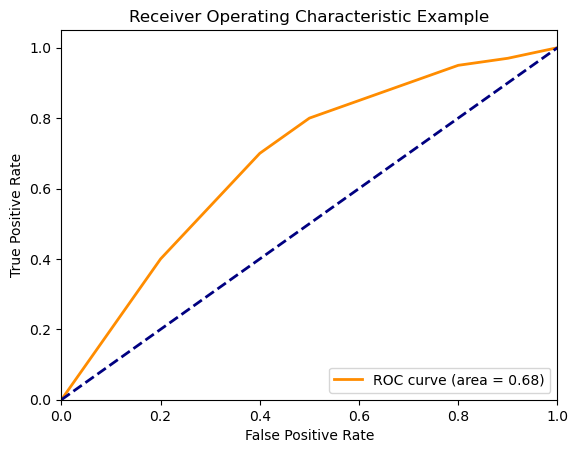

0.6819999999999999

In [80]:
# Define FPRs and TPRs
fprs = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
tprs = np.array([0.0, 0.2, 0.4, 0.55, 0.7, 0.8, 0.85, 0.9, 0.95, 0.97, 1.0])

# Calculate the AUC
roc_auc = auc(fprs, tprs)

# Plot the ROC curve
plt.figure()
plt.plot(fprs, tprs, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()

roc_auc

In [81]:
pDisease = 0.5
dU = -0.05
uTPs = np.arange(0, 1.02, 0.05)
costRatios = []
costRatios = np.append(costRatios, np.arange(0.5, 1, 0.1))
costRatios = np.append(costRatios, np.arange(1, 21, 0.1))

In [82]:
maxEUs, pLs, pUs = cup(pDisease, fprs, tprs, costRatios, uTPs, dU)

0.0
Ratio between misclassifying a fn and a fp is: 0.5
Desired slope is: 2.0, given pDisease: 0.5 and maxNNT: 2.0
Closest slope is: 2.0, corresponding to fpr: 0.0 and tpr: 0.0
0
0
0.0
0.0
Ratio between misclassifying a fn and a fp is: 0.6
Desired slope is: 1.667, given pDisease: 0.5 and maxNNT: 1.667
Closest slope is: 1.7, corresponding to fpr: 0.2 and tpr: 0.4
0
0
0.4003003003003003
0.20020020020020018
Ratio between misclassifying a fn and a fp is: 0.7
Desired slope is: 1.429, given pDisease: 0.5 and maxNNT: 1.429
Closest slope is: 1.4, corresponding to fpr: 0.399 and tpr: 0.699
0
0
0.6990990990990991
0.3993993993993994
Ratio between misclassifying a fn and a fp is: 0.7999999999999999
Desired slope is: 1.25, given pDisease: 0.5 and maxNNT: 1.25
Closest slope is: 1.15, corresponding to fpr: 0.4 and tpr: 0.7
0
0
0.7004004004004003
0.40040040040040037
Ratio between misclassifying a fn and a fp is: 0.8999999999999999
Desired slope is: 1.111, given pDisease: 0.5 and maxNNT: 1.111
Closest s

1
0
0.7004004004004003
0.40040040040040037
Ratio between misclassifying a fn and a fp is: 0.8999999999999999
Desired slope is: 1.111, given pDisease: 0.5 and maxNNT: 1.111
Closest slope is: 1.15, corresponding to fpr: 0.4 and tpr: 0.7
1
0
0.7004004004004003
0.40040040040040037
Ratio between misclassifying a fn and a fp is: 1.0
Desired slope is: 1.0, given pDisease: 0.5 and maxNNT: 1.0
Closest slope is: 1.0, corresponding to fpr: 0.403 and tpr: 0.703
1
0
0.7034034034034033
0.4034034034034034
Ratio between misclassifying a fn and a fp is: 1.1
Desired slope is: 0.909, given pDisease: 0.5 and maxNNT: 0.909
Closest slope is: 0.875, corresponding to fpr: 0.499 and tpr: 0.799
1
0
0.7994994994994995
0.4994994994994995
Ratio between misclassifying a fn and a fp is: 1.2000000000000002
Desired slope is: 0.833, given pDisease: 0.5 and maxNNT: 0.833
Closest slope is: 0.875, corresponding to fpr: 0.499 and tpr: 0.799
1
0
0.7994994994994995
0.4994994994994995
Ratio between misclassifying a fn and a f

1
0
0.9501601601601601
0.8008008008008007
Ratio between misclassifying a fn and a fp is: 4.5000000000000036
Desired slope is: 0.222, given pDisease: 0.5 and maxNNT: 0.222
Closest slope is: 0.23, corresponding to fpr: 0.801 and tpr: 0.95
1
0
0.9501601601601601
0.8008008008008007
Ratio between misclassifying a fn and a fp is: 4.600000000000003
Desired slope is: 0.217, given pDisease: 0.5 and maxNNT: 0.217
Closest slope is: 0.23, corresponding to fpr: 0.801 and tpr: 0.95
1
0
0.9501601601601601
0.8008008008008007
Ratio between misclassifying a fn and a fp is: 4.700000000000003
Desired slope is: 0.213, given pDisease: 0.5 and maxNNT: 0.213
Closest slope is: 0.2, corresponding to fpr: 0.861 and tpr: 0.962
1
0
0.9621721721721721
0.8608608608608609
Ratio between misclassifying a fn and a fp is: 4.800000000000003
Desired slope is: 0.208, given pDisease: 0.5 and maxNNT: 0.208
Closest slope is: 0.2, corresponding to fpr: 0.861 and tpr: 0.962
1
0
0.9621721721721721
0.8608608608608609
Ratio between

1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.600000000000007
Desired slope is: 0.116, given pDisease: 0.5 and maxNNT: 0.116
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.700000000000006
Desired slope is: 0.115, given pDisease: 0.5 and maxNNT: 0.115
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.800000000000008
Desired slope is: 0.114, given pDisease: 0.5 and maxNNT: 0.114
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.900000000000007
Desired slope is: 0.112, given pDisease: 0.5 and maxNNT: 0.112
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between 

Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.800000000000011
Desired slope is: 0.078, given pDisease: 0.5 and maxNNT: 0.078
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.900000000000011
Desired slope is: 0.078, given pDisease: 0.5 and maxNNT: 0.078
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.00000000000001
Desired slope is: 0.077, given pDisease: 0.5 and maxNNT: 0.077
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.10000000000001
Desired slope is: 0.076, given pDisease: 0.5 and maxNNT: 0.076
Closest slope is: 0.2, corresponding to fpr: 0.835 and

Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.100000000000016
Desired slope is: 0.058, given pDisease: 0.5 and maxNNT: 0.058
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.200000000000014
Desired slope is: 0.058, given pDisease: 0.5 and maxNNT: 0.058
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.300000000000015
Desired slope is: 0.058, given pDisease: 0.5 and maxNNT: 0.058
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
1
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.400000000000013
Desired slope is: 0.057, given pDisease: 0.5 and maxNNT: 0.057
Closest slope is: 0.2, corresponding to fpr: 0.835 a

0.8431882686849568
0.3089138964981127
0.6990990990990991
0.3993993993993994
Ratio between misclassifying a fn and a fp is: 0.7999999999999999
Desired slope is: 1.25, given pDisease: 0.5 and maxNNT: 1.25
Closest slope is: 1.15, corresponding to fpr: 0.4 and tpr: 0.7
0.8331249479036428
0.23782262296646084
0.7004004004004003
0.40040040040040037
Ratio between misclassifying a fn and a fp is: 0.8999999999999999
Desired slope is: 1.111, given pDisease: 0.5 and maxNNT: 1.111
Closest slope is: 1.15, corresponding to fpr: 0.4 and tpr: 0.7
0.8250220931700568
0.17210405702638318
0.7004004004004003
0.40040040040040037
Ratio between misclassifying a fn and a fp is: 1.0
Desired slope is: 1.0, given pDisease: 0.5 and maxNNT: 1.0
Closest slope is: 1.0, corresponding to fpr: 0.403 and tpr: 0.703
0.8162250158270761
0.10814748403003355
0.7034034034034033
0.4034034034034034
Ratio between misclassifying a fn and a fp is: 1.1
Desired slope is: 0.909, given pDisease: 0.5 and maxNNT: 0.909
Closest slope is: 0

0.5964739115534238
0
0.9621721721721721
0.8608608608608609
Ratio between misclassifying a fn and a fp is: 4.800000000000003
Desired slope is: 0.208, given pDisease: 0.5 and maxNNT: 0.208
Closest slope is: 0.2, corresponding to fpr: 0.861 and tpr: 0.962
0.5951250025576343
0
0.9621721721721721
0.8608608608608609
Ratio between misclassifying a fn and a fp is: 4.900000000000004
Desired slope is: 0.204, given pDisease: 0.5 and maxNNT: 0.204
Closest slope is: 0.2, corresponding to fpr: 0.861 and tpr: 0.962
0.5938226501630439
0
0.9621721721721721
0.8608608608608609
Ratio between misclassifying a fn and a fp is: 5.0000000000000036
Desired slope is: 0.2, given pDisease: 0.5 and maxNNT: 0.2
Closest slope is: 0.2, corresponding to fpr: 0.803 and tpr: 0.951
0.5944991486563194
0
0.9505605605605605
0.8028028028028028
Ratio between misclassifying a fn and a fp is: 5.100000000000003
Desired slope is: 0.196, given pDisease: 0.5 and maxNNT: 0.196
Closest slope is: 0.2, corresponding to fpr: 0.835 and tp

Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5689125067719363
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.200000000000006
Desired slope is: 0.122, given pDisease: 0.5 and maxNNT: 0.122
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5684007507192772
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.300000000000006
Desired slope is: 0.12, given pDisease: 0.5 and maxNNT: 0.12
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5679001533034495
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.400000000000006
Desired slope is: 0.119, given pDisease: 0.5 and maxNNT: 0.119
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5674103534960387
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.500000000000007
Desired slope is: 0.118, given pDisease: 0.5 and maxN

Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5558837530179344
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.70000000000001
Desired slope is: 0.085, given pDisease: 0.5 and maxNNT: 0.085
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5556180937735516
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.80000000000001
Desired slope is: 0.085, given pDisease: 0.5 and maxNNT: 0.085
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5553566272590524
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.90000000000001
Desired slope is: 0.084, given pDisease: 0.5 and maxNNT: 0.084
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5550992549948146
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.00000000000001
Desired slope is: 0.083, given pDisease: 0.5 and ma

0.547773282745808
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.700000000000014
Desired slope is: 0.064, given pDisease: 0.5 and maxNNT: 0.064
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5476206841769703
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.800000000000013
Desired slope is: 0.063, given pDisease: 0.5 and maxNNT: 0.063
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5474699161639072
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.900000000000013
Desired slope is: 0.063, given pDisease: 0.5 and maxNNT: 0.063
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.547320945964277
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.000000000000014
Desired slope is: 0.062, given pDisease: 0.5 and maxNNT: 0.062
Closest slope is: 0.2, corresponding to fpr: 0.835 a

0.5428321447863035
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.700000000000017
Desired slope is: 0.051, given pDisease: 0.5 and maxNNT: 0.051
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5427332351098632
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.80000000000002
Desired slope is: 0.051, given pDisease: 0.5 and maxNNT: 0.051
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5426352823594888
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.900000000000016
Desired slope is: 0.05, given pDisease: 0.5 and maxNNT: 0.05
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.5425382727150095
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.000000000000018
Desired slope is: 0.05, given pDisease: 0.5 and maxNNT: 0.05
Closest slope is: 0.2, corresponding to fpr: 0.835 and 

0.5144456268968507
0
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.6000000000000014
Desired slope is: 0.385, given pDisease: 0.5 and maxNNT: 0.385
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.5096945445416338
0
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.7000000000000015
Desired slope is: 0.37, given pDisease: 0.5 and maxNNT: 0.37
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.5052117346217755
0
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.8000000000000016
Desired slope is: 0.357, given pDisease: 0.5 and maxNNT: 0.357
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.5009750988119418
0
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.9000000000000017
Desired slope is: 0.345, given pDisease: 0.5 and maxNNT: 0.345
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr:

0.42985984435752245
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 6.200000000000005
Desired slope is: 0.161, given pDisease: 0.5 and maxNNT: 0.161
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.4287069484957092
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 6.300000000000004
Desired slope is: 0.159, given pDisease: 0.5 and maxNNT: 0.159
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.4275862008618232
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 6.400000000000005
Desired slope is: 0.156, given pDisease: 0.5 and maxNNT: 0.156
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.42649627527736833
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 6.500000000000005
Desired slope is: 0.154, given pDisease: 0.5 and maxNNT: 0.154
Closest slope is: 0.2, corresponding to fpr: 0.835 a

0.4001353327420879
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.200000000000008
Desired slope is: 0.098, given pDisease: 0.5 and maxNNT: 0.098
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.39966738785534967
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.300000000000008
Desired slope is: 0.097, given pDisease: 0.5 and maxNNT: 0.097
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.3992078197882709
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.40000000000001
Desired slope is: 0.096, given pDisease: 0.5 and maxNNT: 0.096
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.39875640560241116
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.500000000000009
Desired slope is: 0.095, given pDisease: 0.5 and maxNNT: 0.095
Closest slope is: 0.2, corresponding to fpr: 0.83

0.3862931430714029
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.200000000000012
Desired slope is: 0.07, given pDisease: 0.5 and maxNNT: 0.07
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.3860412224236207
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.300000000000011
Desired slope is: 0.07, given pDisease: 0.5 and maxNNT: 0.07
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.3857926225563242
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.400000000000013
Desired slope is: 0.069, given pDisease: 0.5 and maxNNT: 0.069
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.3855472782384012
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.500000000000012
Desired slope is: 0.069, given pDisease: 0.5 and maxNNT: 0.069
Closest slope is: 0.2, corresponding to fpr: 0.835 and

0.3782877299047764
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.200000000000017
Desired slope is: 0.055, given pDisease: 0.5 and maxNNT: 0.055
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.3781306177866508
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.300000000000015
Desired slope is: 0.055, given pDisease: 0.5 and maxNNT: 0.055
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.3779751446111329
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.400000000000016
Desired slope is: 0.054, given pDisease: 0.5 and maxNNT: 0.054
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.37782128486591493
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.500000000000014
Desired slope is: 0.054, given pDisease: 0.5 and maxNNT: 0.054
Closest slope is: 0.2, corresponding to fpr: 0.83

Closest slope is: 1.15, corresponding to fpr: 0.4 and tpr: 0.7
0.6067367173919344
0.430951092276333
0.7004004004004003
0.40040040040040037
Ratio between misclassifying a fn and a fp is: 1.0
Desired slope is: 1.0, given pDisease: 0.5 and maxNNT: 1.0
Closest slope is: 1.0, corresponding to fpr: 0.403 and tpr: 0.703
0.5903500045220247
0.38804213829429635
0.7034034034034033
0.4034034034034034
Ratio between misclassifying a fn and a fp is: 1.1
Desired slope is: 0.909, given pDisease: 0.5 and maxNNT: 0.909
Closest slope is: 0.875, corresponding to fpr: 0.499 and tpr: 0.799
0.5616592986200339
0.3127386059167321
0.7994994994994995
0.4994994994994995
Ratio between misclassifying a fn and a fp is: 1.2000000000000002
Desired slope is: 0.833, given pDisease: 0.5 and maxNNT: 0.833
Closest slope is: 0.875, corresponding to fpr: 0.499 and tpr: 0.799
0.5480156987594685
0.2705440596466577
0.7994994994994995
0.4994994994994995
Ratio between misclassifying a fn and a fp is: 1.3000000000000003
Desired slo

0.3761184170142612
0
0.9621721721721721
0.8608608608608609
Ratio between misclassifying a fn and a fp is: 4.900000000000004
Desired slope is: 0.204, given pDisease: 0.5 and maxNNT: 0.204
Closest slope is: 0.2, corresponding to fpr: 0.861 and tpr: 0.962
0.3741115910095091
0
0.9621721721721721
0.8608608608608609
Ratio between misclassifying a fn and a fp is: 5.0000000000000036
Desired slope is: 0.2, given pDisease: 0.5 and maxNNT: 0.2
Closest slope is: 0.2, corresponding to fpr: 0.803 and tpr: 0.951
0.3695011756650844
0
0.9505605605605605
0.8028028028028028
Ratio between misclassifying a fn and a fp is: 5.100000000000003
Desired slope is: 0.196, given pDisease: 0.5 and maxNNT: 0.196
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.3691512843779765
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.200000000000004
Desired slope is: 0.192, given pDisease: 0.5 and maxNNT: 0.192
Closest slope is: 0.2, corresponding to fpr: 0.835 and tp

0.32787246909446793
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.900000000000007
Desired slope is: 0.112, given pDisease: 0.5 and maxNNT: 0.112
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.3271906448056837
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.000000000000007
Desired slope is: 0.111, given pDisease: 0.5 and maxNNT: 0.111
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.32652263328703207
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.100000000000007
Desired slope is: 0.11, given pDisease: 0.5 and maxNNT: 0.11
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.3258680190075385
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.200000000000006
Desired slope is: 0.109, given pDisease: 0.5 and maxNNT: 0.109
Closest slope is: 0.2, corresponding to fpr: 0.835 and

0.3083790225146983
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.900000000000011
Desired slope is: 0.078, given pDisease: 0.5 and maxNNT: 0.078
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.3080367650426316
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.00000000000001
Desired slope is: 0.077, given pDisease: 0.5 and maxNNT: 0.077
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.3076994419448461
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.10000000000001
Desired slope is: 0.076, given pDisease: 0.5 and maxNNT: 0.076
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.30736694727570146
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.20000000000001
Desired slope is: 0.076, given pDisease: 0.5 and maxNNT: 0.076
Closest slope is: 0.2, corresponding to fpr: 0.835 a

0.29770994535177603
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.900000000000013
Desired slope is: 0.059, given pDisease: 0.5 and maxNNT: 0.059
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2975047510180499
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.000000000000014
Desired slope is: 0.059, given pDisease: 0.5 and maxNNT: 0.059
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2973018529020837
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.100000000000016
Desired slope is: 0.058, given pDisease: 0.5 and maxNNT: 0.058
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.29710121267475814
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.200000000000014
Desired slope is: 0.058, given pDisease: 0.5 and maxNNT: 0.058
Closest slope is: 0.2, corresponding to fpr: 0.8

0.2909791820148928
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.900000000000016
Desired slope is: 0.048, given pDisease: 0.5 and maxNNT: 0.048
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.29084260002193674
0
0.9569669669669669
0.8348348348348348
0.25
Ratio between misclassifying a fn and a fp is: 0.5
Desired slope is: 2.0, given pDisease: 0.5 and maxNNT: 2.0
Closest slope is: 2.0, corresponding to fpr: 0.0 and tpr: 0.0
0
0.6
0.0
0.0
Ratio between misclassifying a fn and a fp is: 0.6
Desired slope is: 1.667, given pDisease: 0.5 and maxNNT: 1.667
Closest slope is: 1.7, corresponding to fpr: 0.2 and tpr: 0.4
0.7270991498840758
0.5862265421335221
0.4003003003003003
0.20020020020020018
Ratio between misclassifying a fn and a fp is: 0.7
Desired slope is: 1.429, given pDisease: 0.5 and maxNNT: 1.429
Closest slope is: 1.4, corresponding to fpr: 0.399 and tpr: 0.699
0.6069063386944201
0.5677796698008452
0.6990990990990991
0.399

0.37257574169200003
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.6000000000000023
Desired slope is: 0.278, given pDisease: 0.5 and maxNNT: 0.278
Closest slope is: 0.295, corresponding to fpr: 0.901 and tpr: 0.97
0.3689001886328237
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.7000000000000024
Desired slope is: 0.27, given pDisease: 0.5 and maxNNT: 0.27
Closest slope is: 0.295, corresponding to fpr: 0.901 and tpr: 0.97
0.36538345804329
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.8000000000000025
Desired slope is: 0.263, given pDisease: 0.5 and maxNNT: 0.263
Closest slope is: 0.245, corresponding to fpr: 0.9 and tpr: 0.97
0.3619632946378247
0
0.96997997997998
0.8998998998998999
Ratio between misclassifying a fn and a fp is: 3.9000000000000026
Desired slope is: 0.256, given pDisease: 0.5 and maxNNT: 0.256
Closest slope is: 0.245, corresponding to fpr: 0.9 and

0.29343111042506365
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.400000000000006
Desired slope is: 0.135, given pDisease: 0.5 and maxNNT: 0.135
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.29241039421764514
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.500000000000005
Desired slope is: 0.133, given pDisease: 0.5 and maxNNT: 0.133
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.29141406096269656
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.600000000000006
Desired slope is: 0.132, given pDisease: 0.5 and maxNNT: 0.132
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.29044124727952086
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.700000000000006
Desired slope is: 0.13, given pDisease: 0.5 and maxNNT: 0.13
Closest slope is: 0.2, corresponding to fpr: 0.835 a

0.26568386306574604
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.40000000000001
Desired slope is: 0.088, given pDisease: 0.5 and maxNNT: 0.088
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.26522192941768485
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.500000000000009
Desired slope is: 0.087, given pDisease: 0.5 and maxNNT: 0.087
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.26476746294739323
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.600000000000009
Desired slope is: 0.086, given pDisease: 0.5 and maxNNT: 0.086
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2643202840456788
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.70000000000001
Desired slope is: 0.085, given pDisease: 0.5 and maxNNT: 0.085
Closest slope is: 0.2, corresponding to fpr: 0.83

0.2533063815869949
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.800000000000011
Desired slope is: 0.068, given pDisease: 0.5 and maxNNT: 0.068
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.25302363727084987
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.900000000000013
Desired slope is: 0.067, given pDisease: 0.5 and maxNNT: 0.067
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2527444782651175
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.000000000000012
Desired slope is: 0.067, given pDisease: 0.5 and maxNNT: 0.067
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.25246883680469706
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.100000000000012
Desired slope is: 0.066, given pDisease: 0.5 and maxNNT: 0.066
Closest slope is: 0.2, corresponding to fpr: 0.8

0.24555790929920882
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.100000000000016
Desired slope is: 0.055, given pDisease: 0.5 and maxNNT: 0.055
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.24536518552076464
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.200000000000017
Desired slope is: 0.055, given pDisease: 0.5 and maxNNT: 0.055
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.24517448271527498
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.300000000000015
Desired slope is: 0.055, given pDisease: 0.5 and maxNNT: 0.055
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.24498576925953852
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.400000000000016
Desired slope is: 0.054, given pDisease: 0.5 and maxNNT: 0.054
Closest slope is: 0.2, corresponding to fpr: 0

0.5150583340870037
0.4813403563823826
0.7034034034034033
0.4034034034034034
Ratio between misclassifying a fn and a fp is: 1.1
Desired slope is: 0.909, given pDisease: 0.5 and maxNNT: 0.909
Closest slope is: 0.875, corresponding to fpr: 0.499 and tpr: 0.799
0.4951835478414885
0.4398678383518652
0.7994994994994995
0.4994994994994995
Ratio between misclassifying a fn and a fp is: 1.2000000000000002
Desired slope is: 0.833, given pDisease: 0.5 and maxNNT: 0.833
Closest slope is: 0.875, corresponding to fpr: 0.499 and tpr: 0.799
0.47947085300252495
0.4054784159057755
0.7994994994994995
0.4994994994994995
Ratio between misclassifying a fn and a fp is: 1.3000000000000003
Desired slope is: 0.769, given pDisease: 0.5 and maxNNT: 0.769
Closest slope is: 0.875, corresponding to fpr: 0.499 and tpr: 0.799
0.4653908450475175
0.37290074830021364
0.7994994994994995
0.4994994994994995
Ratio between misclassifying a fn and a fp is: 1.4000000000000004
Desired slope is: 0.714, given pDisease: 0.5 and max

0.3008745712916619
0
0.9621721721721721
0.8608608608608609
Ratio between misclassifying a fn and a fp is: 5.0000000000000036
Desired slope is: 0.2, given pDisease: 0.5 and maxNNT: 0.2
Closest slope is: 0.2, corresponding to fpr: 0.803 and tpr: 0.951
0.29450185133467305
0
0.9505605605605605
0.8028028028028028
Ratio between misclassifying a fn and a fp is: 5.100000000000003
Desired slope is: 0.196, given pDisease: 0.5 and maxNNT: 0.196
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.29479034708075846
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.200000000000004
Desired slope is: 0.192, given pDisease: 0.5 and maxNNT: 0.192
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.29280382660391
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.300000000000004
Desired slope is: 0.189, given pDisease: 0.5 and maxNNT: 0.189
Closest slope is: 0.2, corresponding to fpr: 0.835 and tp

0.2478836207353307
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.000000000000007
Desired slope is: 0.111, given pDisease: 0.5 and maxNNT: 0.111
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.24713686773489113
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.100000000000007
Desired slope is: 0.11, given pDisease: 0.5 and maxNNT: 0.11
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.24640509116563528
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.200000000000006
Desired slope is: 0.109, given pDisease: 0.5 and maxNNT: 0.109
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.24568784496305685
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.300000000000008
Desired slope is: 0.108, given pDisease: 0.5 and maxNNT: 0.108
Closest slope is: 0.2, corresponding to fpr: 0.835 an

Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.22927311947311638
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.30000000000001
Desired slope is: 0.081, given pDisease: 0.5 and maxNNT: 0.081
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.22885473054984964
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.40000000000001
Desired slope is: 0.081, given pDisease: 0.5 and maxNNT: 0.081
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.22844264628415406
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.50000000000001
Desired slope is: 0.08, given pDisease: 0.5 and maxNNT: 0.08
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.22803672523539967
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.60000000000001
Desired slope is: 0.079, given pDisease: 0.5 and 

0.21843526529075788
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.500000000000012
Desired slope is: 0.065, given pDisease: 0.5 and maxNNT: 0.065
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.21816484694919036
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.600000000000012
Desired slope is: 0.064, given pDisease: 0.5 and maxNNT: 0.064
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2178977119025723
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.700000000000014
Desired slope is: 0.064, given pDisease: 0.5 and maxNNT: 0.064
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2176338007153404
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.800000000000013
Desired slope is: 0.063, given pDisease: 0.5 and maxNNT: 0.063
Closest slope is: 0.2, corresponding to fpr: 0.8

Ratio between misclassifying a fn and a fp is: 18.800000000000015
Desired slope is: 0.053, given pDisease: 0.5 and maxNNT: 0.053
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.21078335350668592
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.900000000000016
Desired slope is: 0.053, given pDisease: 0.5 and maxNNT: 0.053
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.21059813552524467
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.000000000000014
Desired slope is: 0.053, given pDisease: 0.5 and maxNNT: 0.053
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.21041478161866975
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.100000000000016
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2102332637871648
0
0.9569669669669669


0.36771904388784254
0.1427642969104156
0.8367867867867868
0.5735735735735735
Ratio between misclassifying a fn and a fp is: 2.300000000000001
Desired slope is: 0.435, given pDisease: 0.5 and maxNNT: 0.435
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.37806832847054733
0
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.4000000000000012
Desired slope is: 0.417, given pDisease: 0.5 and maxNNT: 0.417
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.3710455734197146
0
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.5000000000000013
Desired slope is: 0.4, given pDisease: 0.5 and maxNNT: 0.4
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.36444309307026584
0
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.6000000000000014
Desired slope is: 0.385, given pDisease: 0.5 and maxNNT: 0.385
Closest slope is: 0.38, corresponding to 

Ratio between misclassifying a fn and a fp is: 5.600000000000004
Desired slope is: 0.179, given pDisease: 0.5 and maxNNT: 0.179
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.26394486054169713
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.700000000000005
Desired slope is: 0.175, given pDisease: 0.5 and maxNNT: 0.175
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.26220022968524476
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.800000000000004
Desired slope is: 0.172, given pDisease: 0.5 and maxNNT: 0.172
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2605078929712597
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.900000000000004
Desired slope is: 0.169, given pDisease: 0.5 and maxNNT: 0.169
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2588655338946911
0
0.9569669669669669
0.834

0.22014822891717287
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.700000000000008
Desired slope is: 0.103, given pDisease: 0.5 and maxNNT: 0.103
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2194779248525666
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.800000000000008
Desired slope is: 0.102, given pDisease: 0.5 and maxNNT: 0.102
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2188201822658625
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.900000000000007
Desired slope is: 0.101, given pDisease: 0.5 and maxNNT: 0.101
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.21817465133233754
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.000000000000007
Desired slope is: 0.1, given pDisease: 0.5 and maxNNT: 0.1
Closest slope is: 0.2, corresponding to fpr: 0.835 and 

0.20056137857171402
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.700000000000012
Desired slope is: 0.073, given pDisease: 0.5 and maxNNT: 0.073
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.20020947840725653
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.800000000000011
Desired slope is: 0.072, given pDisease: 0.5 and maxNNT: 0.072
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.19986237501421517
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.900000000000011
Desired slope is: 0.072, given pDisease: 0.5 and maxNNT: 0.072
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.19951997097891294
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.00000000000001
Desired slope is: 0.071, given pDisease: 0.5 and maxNNT: 0.071
Closest slope is: 0.2, corresponding to fpr: 0.

0.18945718386073718
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.700000000000014
Desired slope is: 0.056, given pDisease: 0.5 and maxNNT: 0.056
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1892408624802983
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.800000000000015
Desired slope is: 0.056, given pDisease: 0.5 and maxNNT: 0.056
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.18902685812028266
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.900000000000016
Desired slope is: 0.056, given pDisease: 0.5 and maxNNT: 0.056
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.18881513375255046
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.000000000000014
Desired slope is: 0.056, given pDisease: 0.5 and maxNNT: 0.056
Closest slope is: 0.2, corresponding to fpr: 0.

0.1833677765183371
0
0.9569669669669669
0.8348348348348348
0.4
Ratio between misclassifying a fn and a fp is: 0.5
Desired slope is: 2.0, given pDisease: 0.5 and maxNNT: 2.0
Closest slope is: 2.0, corresponding to fpr: 0.0 and tpr: 0.0
0
0.625
0.0
0.0
Ratio between misclassifying a fn and a fp is: 0.6
Desired slope is: 1.667, given pDisease: 0.5 and maxNNT: 1.667
Closest slope is: 1.7, corresponding to fpr: 0.2 and tpr: 0.4
0.6249147611037874
0.6250323705609171
0.4003003003003003
0.20020020020020018
Ratio between misclassifying a fn and a fp is: 0.7
Desired slope is: 1.429, given pDisease: 0.5 and maxNNT: 1.429
Closest slope is: 1.4, corresponding to fpr: 0.399 and tpr: 0.699
0.5478358561967828
0.632496113126526
0.6990990990990991
0.3993993993993994
Ratio between misclassifying a fn and a fp is: 0.7999999999999999
Desired slope is: 1.25, given pDisease: 0.5 and maxNNT: 1.25
Closest slope is: 1.15, corresponding to fpr: 0.4 and tpr: 0.7
0.5208593815120447
0.5952721721291923
0.70040040040

0.3074509964733863
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.7000000000000024
Desired slope is: 0.27, given pDisease: 0.5 and maxNNT: 0.27
Closest slope is: 0.295, corresponding to fpr: 0.901 and tpr: 0.97
0.3035918473790855
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.8000000000000025
Desired slope is: 0.263, given pDisease: 0.5 and maxNNT: 0.263
Closest slope is: 0.245, corresponding to fpr: 0.9 and tpr: 0.97
0.2998152464464845
0
0.96997997997998
0.8998998998998999
Ratio between misclassifying a fn and a fp is: 3.9000000000000026
Desired slope is: 0.256, given pDisease: 0.5 and maxNNT: 0.256
Closest slope is: 0.245, corresponding to fpr: 0.9 and tpr: 0.97
0.2962743304549096
0
0.96997997997998
0.8998998998998999
Ratio between misclassifying a fn and a fp is: 4.000000000000003
Desired slope is: 0.25, given pDisease: 0.5 and maxNNT: 0.25
Closest slope is: 0.245, corresponding to fpr: 0.9 and tpr: 

0.22013843516703618
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.700000000000006
Desired slope is: 0.13, given pDisease: 0.5 and maxNNT: 0.13
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2190941807092062
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.800000000000006
Desired slope is: 0.128, given pDisease: 0.5 and maxNNT: 0.128
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.21807400856700557
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.900000000000006
Desired slope is: 0.127, given pDisease: 0.5 and maxNNT: 0.127
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.21707709516711365
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.000000000000007
Desired slope is: 0.125, given pDisease: 0.5 and maxNNT: 0.125
Closest slope is: 0.2, corresponding to fpr: 0.835 an

0.19142941680261427
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.70000000000001
Desired slope is: 0.085, given pDisease: 0.5 and maxNNT: 0.085
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.19094575007881084
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.80000000000001
Desired slope is: 0.085, given pDisease: 0.5 and maxNNT: 0.085
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.19046971675747232
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.90000000000001
Desired slope is: 0.084, given pDisease: 0.5 and maxNNT: 0.084
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1900011375437853
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.00000000000001
Desired slope is: 0.083, given pDisease: 0.5 and maxNNT: 0.083
Closest slope is: 0.2, corresponding to fpr: 0.835 

Ratio between misclassifying a fn and a fp is: 15.700000000000014
Desired slope is: 0.064, given pDisease: 0.5 and maxNNT: 0.064
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.17638544028263722
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.800000000000013
Desired slope is: 0.063, given pDisease: 0.5 and maxNNT: 0.063
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.17611094777964814
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.900000000000013
Desired slope is: 0.063, given pDisease: 0.5 and maxNNT: 0.063
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.17583972842658174
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.000000000000014
Desired slope is: 0.062, given pDisease: 0.5 and maxNNT: 0.062
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.17557172402505633
0
0.9569669669669669

0.16878581591193673
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.100000000000016
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1685947279929899
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.200000000000017
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.16840554406309496
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.300000000000015
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1682182358064635
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.400000000000016
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.8

0.36994602922320113
0.32194507365063174
0.8297797797797798
0.5595595595595596
Ratio between misclassifying a fn and a fp is: 1.9000000000000008
Desired slope is: 0.526, given pDisease: 0.5 and maxNNT: 0.526
Closest slope is: 0.5, corresponding to fpr: 0.56 and tpr: 0.83
0.36077703660488075
0.3002247426598263
0.8297797797797798
0.5595595595595596
Ratio between misclassifying a fn and a fp is: 2.000000000000001
Desired slope is: 0.5, given pDisease: 0.5 and maxNNT: 0.5
Closest slope is: 0.5, corresponding to fpr: 0.502 and tpr: 0.801
0.34413822647436826
0.3080013391362568
0.8007507507507508
0.5015015015015015
Ratio between misclassifying a fn and a fp is: 2.100000000000001
Desired slope is: 0.476, given pDisease: 0.5 and maxNNT: 0.476
Closest slope is: 0.5, corresponding to fpr: 0.574 and tpr: 0.837
0.34618927676460565
0.25103949089347355
0.8367867867867868
0.5735735735735735
Ratio between misclassifying a fn and a fp is: 2.200000000000001
Desired slope is: 0.455, given pDisease: 0.5 and

0.235242553884702
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.700000000000005
Desired slope is: 0.175, given pDisease: 0.5 and maxNNT: 0.175
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2334298915355519
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.800000000000004
Desired slope is: 0.172, given pDisease: 0.5 and maxNNT: 0.172
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.23167156252733634
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.900000000000004
Desired slope is: 0.169, given pDisease: 0.5 and maxNNT: 0.169
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.22996516002340853
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 6.000000000000004
Desired slope is: 0.167, given pDisease: 0.5 and maxNNT: 0.167
Closest slope is: 0.2, corresponding to fpr: 0.835 an

0.1950122713550959
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.000000000000007
Desired slope is: 0.111, given pDisease: 0.5 and maxNNT: 0.111
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.19421302403346447
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.100000000000007
Desired slope is: 0.11, given pDisease: 0.5 and maxNNT: 0.11
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1934298059377005
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.200000000000006
Desired slope is: 0.109, given pDisease: 0.5 and maxNNT: 0.109
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.19266213964640416
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.300000000000008
Desired slope is: 0.108, given pDisease: 0.5 and maxNNT: 0.108
Closest slope is: 0.2, corresponding to fpr: 0.835 and

0.17509351203401846
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.30000000000001
Desired slope is: 0.081, given pDisease: 0.5 and maxNNT: 0.081
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.17464571172236998
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.40000000000001
Desired slope is: 0.081, given pDisease: 0.5 and maxNNT: 0.081
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.174204659265333
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.50000000000001
Desired slope is: 0.08, given pDisease: 0.5 and maxNNT: 0.08
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.17377020327945808
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.60000000000001
Desired slope is: 0.079, given pDisease: 0.5 and maxNNT: 0.079
Closest slope is: 0.2, corresponding to fpr: 0.835 and

0.16127330549987198
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.30000000000001
Desired slope is: 0.061, given pDisease: 0.5 and maxNNT: 0.061
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.16101029161118277
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.400000000000013
Desired slope is: 0.061, given pDisease: 0.5 and maxNNT: 0.061
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.160750323208437
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.500000000000014
Desired slope is: 0.061, given pDisease: 0.5 and maxNNT: 0.061
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.16049334769976098
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.600000000000016
Desired slope is: 0.06, given pDisease: 0.5 and maxNNT: 0.06
Closest slope is: 0.2, corresponding to fpr: 0.835 

Ratio between misclassifying a fn and a fp is: 20.30000000000002
Desired slope is: 0.049, given pDisease: 0.5 and maxNNT: 0.049
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1525270264521973
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.400000000000016
Desired slope is: 0.049, given pDisease: 0.5 and maxNNT: 0.049
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.15235582106038992
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.500000000000018
Desired slope is: 0.049, given pDisease: 0.5 and maxNNT: 0.049
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.15218621778706715
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.600000000000016
Desired slope is: 0.049, given pDisease: 0.5 and maxNNT: 0.049
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.15201819424832844
0
0.9569669669669669
0

0.3065963944910594
0
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 3.0000000000000018
Desired slope is: 0.333, given pDisease: 0.5 and maxNNT: 0.333
Closest slope is: 0.3, corresponding to fpr: 0.944 and tpr: 0.983
0.3194930069930073
0
0.9831831831831832
0.943943943943944
Ratio between misclassifying a fn and a fp is: 3.100000000000002
Desired slope is: 0.323, given pDisease: 0.5 and maxNNT: 0.323
Closest slope is: 0.3, corresponding to fpr: 0.944 and tpr: 0.983
0.31412902287465294
0
0.9831831831831832
0.943943943943944
Ratio between misclassifying a fn and a fp is: 3.200000000000002
Desired slope is: 0.312, given pDisease: 0.5 and maxNNT: 0.312
Closest slope is: 0.3, corresponding to fpr: 0.944 and tpr: 0.983
0.30902291705416446
0
0.9831831831831832
0.943943943943944
Ratio between misclassifying a fn and a fp is: 3.300000000000002
Desired slope is: 0.303, given pDisease: 0.5 and maxNNT: 0.303
Closest slope is: 0.3, corresponding to fpr: 0.944 and

0.20500859367019714
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.000000000000005
Desired slope is: 0.143, given pDisease: 0.5 and maxNNT: 0.143
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.20373182816529817
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.100000000000005
Desired slope is: 0.141, given pDisease: 0.5 and maxNNT: 0.141
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.20248709239745485
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.2000000000000055
Desired slope is: 0.139, given pDisease: 0.5 and maxNNT: 0.139
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.20127319602056343
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.300000000000006
Desired slope is: 0.137, given pDisease: 0.5 and maxNNT: 0.137
Closest slope is: 0.2, corresponding to fpr: 0.83

0.17085685390628777
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.000000000000009
Desired slope is: 0.091, given pDisease: 0.5 and maxNNT: 0.091
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.17029790900704952
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.100000000000009
Desired slope is: 0.09, given pDisease: 0.5 and maxNNT: 0.09
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1697483013506109
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.20000000000001
Desired slope is: 0.089, given pDisease: 0.5 and maxNNT: 0.089
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1692077989053584
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.30000000000001
Desired slope is: 0.088, given pDisease: 0.5 and maxNNT: 0.088
Closest slope is: 0.2, corresponding to fpr: 0.835 a

0.15632774903947735
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.300000000000011
Desired slope is: 0.07, given pDisease: 0.5 and maxNNT: 0.07
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.15598613520921792
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.400000000000013
Desired slope is: 0.069, given pDisease: 0.5 and maxNNT: 0.069
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1556489949963509
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.500000000000012
Desired slope is: 0.069, given pDisease: 0.5 and maxNNT: 0.069
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1553162410958795
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.600000000000012
Desired slope is: 0.068, given pDisease: 0.5 and maxNNT: 0.068
Closest slope is: 0.2, corresponding to fpr: 0.835

0.1470180068235487
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.600000000000016
Desired slope is: 0.057, given pDisease: 0.5 and maxNNT: 0.057
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1467878188262411
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.700000000000014
Desired slope is: 0.056, given pDisease: 0.5 and maxNNT: 0.056
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1465601096501638
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.800000000000015
Desired slope is: 0.056, given pDisease: 0.5 and maxNNT: 0.056
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.14633483946929976
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.900000000000016
Desired slope is: 0.056, given pDisease: 0.5 and maxNNT: 0.056
Closest slope is: 0.2, corresponding to fpr: 0.83

0.1405434082558394
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.900000000000016
Desired slope is: 0.048, given pDisease: 0.5 and maxNNT: 0.048
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1403778471168976
0
0.9569669669669669
0.8348348348348348
0.55
Ratio between misclassifying a fn and a fp is: 0.5
Desired slope is: 2.0, given pDisease: 0.5 and maxNNT: 2.0
Closest slope is: 2.0, corresponding to fpr: 0.0 and tpr: 0.0
0
0.6363636363636364
0.0
0.0
Ratio between misclassifying a fn and a fp is: 0.6
Desired slope is: 1.667, given pDisease: 0.5 and maxNNT: 1.667
Closest slope is: 1.7, corresponding to fpr: 0.2 and tpr: 0.4
0.5784673116582018
0.6426713834824632
0.4003003003003003
0.20020020020020018
Ratio between misclassifying a fn and a fp is: 0.7
Desired slope is: 1.429, given pDisease: 0.5 and maxNNT: 1.429
Closest slope is: 1.4, corresponding to fpr: 0.399 and tpr: 0.699
0.5209856368796771
0.6619126782745652
0.69909909

0.28371565534790266
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.6000000000000023
Desired slope is: 0.278, given pDisease: 0.5 and maxNNT: 0.278
Closest slope is: 0.295, corresponding to fpr: 0.901 and tpr: 0.97
0.27951954549182534
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.7000000000000024
Desired slope is: 0.27, given pDisease: 0.5 and maxNNT: 0.27
Closest slope is: 0.295, corresponding to fpr: 0.901 and tpr: 0.97
0.2755047516226274
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.8000000000000025
Desired slope is: 0.263, given pDisease: 0.5 and maxNNT: 0.263
Closest slope is: 0.245, corresponding to fpr: 0.9 and tpr: 0.97
0.27156613363223897
0
0.96997997997998
0.8998998998998999
Ratio between misclassifying a fn and a fp is: 3.9000000000000026
Desired slope is: 0.256, given pDisease: 0.5 and maxNNT: 0.256
Closest slope is: 0.245, corresponding to fpr: 0.9

0.19280011240901027
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.300000000000006
Desired slope is: 0.137, given pDisease: 0.5 and maxNNT: 0.137
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1916033611800322
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.400000000000006
Desired slope is: 0.135, given pDisease: 0.5 and maxNNT: 0.135
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1904355436275753
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.500000000000005
Desired slope is: 0.133, given pDisease: 0.5 and maxNNT: 0.133
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1892956229965812
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.600000000000006
Desired slope is: 0.132, given pDisease: 0.5 and maxNNT: 0.132
Closest slope is: 0.2, corresponding to fpr: 0.835 an

0.16381481480928894
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.700000000000008
Desired slope is: 0.093, given pDisease: 0.5 and maxNNT: 0.093
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1632201425355497
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.800000000000008
Desired slope is: 0.093, given pDisease: 0.5 and maxNNT: 0.093
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1626356596574113
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.90000000000001
Desired slope is: 0.092, given pDisease: 0.5 and maxNNT: 0.092
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.16206110651456962
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.000000000000009
Desired slope is: 0.091, given pDisease: 0.5 and maxNNT: 0.091
Closest slope is: 0.2, corresponding to fpr: 0.83

0.14602369825343503
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.700000000000012
Desired slope is: 0.068, given pDisease: 0.5 and maxNNT: 0.068
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.14569602446475338
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.800000000000011
Desired slope is: 0.068, given pDisease: 0.5 and maxNNT: 0.068
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.14537253222190272
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.900000000000013
Desired slope is: 0.067, given pDisease: 0.5 and maxNNT: 0.067
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.14505314198938576
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.000000000000012
Desired slope is: 0.067, given pDisease: 0.5 and maxNNT: 0.067
Closest slope is: 0.2, corresponding to fpr: 0

Ratio between misclassifying a fn and a fp is: 18.700000000000017
Desired slope is: 0.053, given pDisease: 0.5 and maxNNT: 0.053
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1353347028737102
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.800000000000015
Desired slope is: 0.053, given pDisease: 0.5 and maxNNT: 0.053
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1351296559652093
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.900000000000016
Desired slope is: 0.053, given pDisease: 0.5 and maxNNT: 0.053
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1349266831312704
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.000000000000014
Desired slope is: 0.053, given pDisease: 0.5 and maxNNT: 0.053
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13472575306097354
0
0.9569669669669669
0.

Ratio between misclassifying a fn and a fp is: 1.5000000000000004
Desired slope is: 0.667, given pDisease: 0.5 and maxNNT: 0.667
Closest slope is: 0.625, corresponding to fpr: 0.501 and tpr: 0.8
0.3677519972928032
0.4686374596812076
0.8002502502502503
0.5005005005005005
Ratio between misclassifying a fn and a fp is: 1.6000000000000005
Desired slope is: 0.625, given pDisease: 0.5 and maxNNT: 0.625
Closest slope is: 0.625, corresponding to fpr: 0.501 and tpr: 0.8
0.35590629075048374
0.447035244659529
0.8002502502502503
0.5005005005005005
Ratio between misclassifying a fn and a fp is: 1.7000000000000006
Desired slope is: 0.588, given pDisease: 0.5 and maxNNT: 0.588
Closest slope is: 0.625, corresponding to fpr: 0.501 and tpr: 0.8
0.3450793813018912
0.4264615531444037
0.8002502502502503
0.5005005005005005
Ratio between misclassifying a fn and a fp is: 1.8000000000000007
Desired slope is: 0.556, given pDisease: 0.5 and maxNNT: 0.556
Closest slope is: 0.5, corresponding to fpr: 0.56 and tpr:

0.22897138917374438
0
0.9501601601601601
0.8008008008008007
Ratio between misclassifying a fn and a fp is: 4.700000000000003
Desired slope is: 0.213, given pDisease: 0.5 and maxNNT: 0.213
Closest slope is: 0.2, corresponding to fpr: 0.861 and tpr: 0.962
0.23267903096628736
0
0.9621721721721721
0.8608608608608609
Ratio between misclassifying a fn and a fp is: 4.800000000000003
Desired slope is: 0.208, given pDisease: 0.5 and maxNNT: 0.208
Closest slope is: 0.2, corresponding to fpr: 0.861 and tpr: 0.962
0.2301140266520132
0
0.9621721721721721
0.8608608608608609
Ratio between misclassifying a fn and a fp is: 4.900000000000004
Desired slope is: 0.204, given pDisease: 0.5 and maxNNT: 0.204
Closest slope is: 0.2, corresponding to fpr: 0.861 and tpr: 0.962
0.22763755157381632
0
0.9621721721721721
0.8608608608608609
Ratio between misclassifying a fn and a fp is: 5.0000000000000036
Desired slope is: 0.2, given pDisease: 0.5 and maxNNT: 0.2
Closest slope is: 0.2, corresponding to fpr: 0.803 and

0.17115765718908502
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.700000000000006
Desired slope is: 0.115, given pDisease: 0.5 and maxNNT: 0.115
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.17027932792403977
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.800000000000008
Desired slope is: 0.114, given pDisease: 0.5 and maxNNT: 0.114
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.16941916026235004
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.900000000000007
Desired slope is: 0.112, given pDisease: 0.5 and maxNNT: 0.112
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.16857659666497896
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.000000000000007
Desired slope is: 0.111, given pDisease: 0.5 and maxNNT: 0.111
Closest slope is: 0.2, corresponding to fpr: 0.835

0.1461948802327005
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.70000000000001
Desired slope is: 0.079, given pDisease: 0.5 and maxNNT: 0.079
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.14575933230815685
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.800000000000011
Desired slope is: 0.078, given pDisease: 0.5 and maxNNT: 0.078
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.14533015559415524
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.900000000000011
Desired slope is: 0.078, given pDisease: 0.5 and maxNNT: 0.078
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.14490721130831086
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.00000000000001
Desired slope is: 0.077, given pDisease: 0.5 and maxNNT: 0.077
Closest slope is: 0.2, corresponding to fpr: 0.83

0.13456403758906024
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.000000000000014
Desired slope is: 0.062, given pDisease: 0.5 and maxNNT: 0.062
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13428261095984156
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.100000000000016
Desired slope is: 0.062, given pDisease: 0.5 and maxNNT: 0.062
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13400450062095712
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.200000000000014
Desired slope is: 0.062, given pDisease: 0.5 and maxNNT: 0.062
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1337296482977338
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.30000000000001
Desired slope is: 0.061, given pDisease: 0.5 and maxNNT: 0.061
Closest slope is: 0.2, corresponding to fpr: 0.8

Ratio between misclassifying a fn and a fp is: 19.200000000000017
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1267575335372793
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.300000000000015
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12656084448669488
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.400000000000016
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1263660958998471
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.500000000000018
Desired slope is: 0.051, given pDisease: 0.5 and maxNNT: 0.051
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1261732592018102
0
0.9569669669669669
0.

0.30579223395493943
0.0006058219489284568
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.7000000000000015
Desired slope is: 0.37, given pDisease: 0.5 and maxNNT: 0.37
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.2994451671919157
0
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.8000000000000016
Desired slope is: 0.357, given pDisease: 0.5 and maxNNT: 0.357
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.29344665045434193
0
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.9000000000000017
Desired slope is: 0.345, given pDisease: 0.5 and maxNNT: 0.345
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.28776874000201313
0
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 3.0000000000000018
Desired slope is: 0.333, given pDisease: 0.5 and maxNNT: 0.333
Closest slope is: 0.3, correspondin

0.19223524944727266
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 6.400000000000005
Desired slope is: 0.156, given pDisease: 0.5 and maxNNT: 0.156
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1906971952124292
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 6.500000000000005
Desired slope is: 0.154, given pDisease: 0.5 and maxNNT: 0.154
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.18920086576954032
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 6.600000000000005
Desired slope is: 0.152, given pDisease: 0.5 and maxNNT: 0.152
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.18774458595693203
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 6.700000000000005
Desired slope is: 0.149, given pDisease: 0.5 and maxNNT: 0.149
Closest slope is: 0.2, corresponding to fpr: 0.835 

0.15218894737789368
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.40000000000001
Desired slope is: 0.096, given pDisease: 0.5 and maxNNT: 0.096
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.15155193186955587
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.500000000000009
Desired slope is: 0.095, given pDisease: 0.5 and maxNNT: 0.095
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.15092611921836857
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.600000000000009
Desired slope is: 0.094, given pDisease: 0.5 and maxNNT: 0.094
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.15031121647217974
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.700000000000008
Desired slope is: 0.093, given pDisease: 0.5 and maxNNT: 0.093
Closest slope is: 0.2, corresponding to fpr: 0.

0.13325802107598786
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.400000000000013
Desired slope is: 0.069, given pDisease: 0.5 and maxNNT: 0.069
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13291180214823606
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.500000000000012
Desired slope is: 0.069, given pDisease: 0.5 and maxNNT: 0.069
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1325700876501444
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.600000000000012
Desired slope is: 0.068, given pDisease: 0.5 and maxNNT: 0.068
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13223279024354842
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 14.700000000000012
Desired slope is: 0.068, given pDisease: 0.5 and maxNNT: 0.068
Closest slope is: 0.2, corresponding to fpr: 0.

Ratio between misclassifying a fn and a fp is: 18.500000000000014
Desired slope is: 0.054, given pDisease: 0.5 and maxNNT: 0.054
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12179434741898348
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.600000000000016
Desired slope is: 0.054, given pDisease: 0.5 and maxNNT: 0.054
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12158167597857344
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.700000000000017
Desired slope is: 0.053, given pDisease: 0.5 and maxNNT: 0.053
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12137117771777545
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.800000000000015
Desired slope is: 0.053, given pDisease: 0.5 and maxNNT: 0.053
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12116281949601336
0
0.9569669669669669

0.32548122962625337
0.3989299216630016
0.8297797797797798
0.5595595595595596
Ratio between misclassifying a fn and a fp is: 2.000000000000001
Desired slope is: 0.5, given pDisease: 0.5 and maxNNT: 0.5
Closest slope is: 0.5, corresponding to fpr: 0.502 and tpr: 0.801
0.30639929825993006
0.39647998469558404
0.8007507507507508
0.5015015015015015
Ratio between misclassifying a fn and a fp is: 2.100000000000001
Desired slope is: 0.476, given pDisease: 0.5 and maxNNT: 0.476
Closest slope is: 0.5, corresponding to fpr: 0.574 and tpr: 0.837
0.31043656954384674
0.35938079528373706
0.8367867867867868
0.5735735735735735
Ratio between misclassifying a fn and a fp is: 2.200000000000001
Desired slope is: 0.455, given pDisease: 0.5 and maxNNT: 0.455
Closest slope is: 0.5, corresponding to fpr: 0.574 and tpr: 0.837
0.3026361845062647
0.3428200044784511
0.8367867867867868
0.5735735735735735
Ratio between misclassifying a fn and a fp is: 2.300000000000001
Desired slope is: 0.435, given pDisease: 0.5 and

0.20980641874108058
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.200000000000004
Desired slope is: 0.192, given pDisease: 0.5 and maxNNT: 0.192
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.20758050517998883
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.300000000000004
Desired slope is: 0.189, given pDisease: 0.5 and maxNNT: 0.189
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.20542671663619744
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.400000000000004
Desired slope is: 0.185, given pDisease: 0.5 and maxNNT: 0.185
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2033416034590732
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.5000000000000036
Desired slope is: 0.182, given pDisease: 0.5 and maxNNT: 0.182
Closest slope is: 0.2, corresponding to fpr: 0.835

0.15641027853244585
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.100000000000007
Desired slope is: 0.11, given pDisease: 0.5 and maxNNT: 0.11
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1555903164891748
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.200000000000006
Desired slope is: 0.109, given pDisease: 0.5 and maxNNT: 0.109
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1547866358487945
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.300000000000008
Desired slope is: 0.108, given pDisease: 0.5 and maxNNT: 0.108
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1539987564461046
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.400000000000007
Desired slope is: 0.106, given pDisease: 0.5 and maxNNT: 0.106
Closest slope is: 0.2, corresponding to fpr: 0.835 and 

0.13325510032728774
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.00000000000001
Desired slope is: 0.077, given pDisease: 0.5 and maxNNT: 0.077
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13283257343600582
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.10000000000001
Desired slope is: 0.076, given pDisease: 0.5 and maxNNT: 0.076
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13241609457688377
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.20000000000001
Desired slope is: 0.076, given pDisease: 0.5 and maxNNT: 0.076
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13200553481578292
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.300000000000011
Desired slope is: 0.075, given pDisease: 0.5 and maxNNT: 0.075
Closest slope is: 0.2, corresponding to fpr: 0.83

0.12006282510525176
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.000000000000014
Desired slope is: 0.059, given pDisease: 0.5 and maxNNT: 0.059
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11980867734380651
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.100000000000016
Desired slope is: 0.058, given pDisease: 0.5 and maxNNT: 0.058
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1195573577867581
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.200000000000014
Desired slope is: 0.058, given pDisease: 0.5 and maxNNT: 0.058
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11930881948613806
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.300000000000015
Desired slope is: 0.058, given pDisease: 0.5 and maxNNT: 0.058
Closest slope is: 0.2, corresponding to fpr: 0.

0.1117178941826045
0
0.9569669669669669
0.8348348348348348
0.75
Ratio between misclassifying a fn and a fp is: 0.5
Desired slope is: 2.0, given pDisease: 0.5 and maxNNT: 2.0
Closest slope is: 2.0, corresponding to fpr: 0.0 and tpr: 0.0
0
0.6444444444444445
0.0
0.0
Ratio between misclassifying a fn and a fp is: 0.6
Desired slope is: 1.667, given pDisease: 0.5 and maxNNT: 1.667
Closest slope is: 1.7, corresponding to fpr: 0.2 and tpr: 0.4
0.5454380142746739
0.6552146815600043
0.4003003003003003
0.20020020020020018
Ratio between misclassifying a fn and a fp is: 0.7
Desired slope is: 1.429, given pDisease: 0.5 and maxNNT: 1.429
Closest slope is: 1.4, corresponding to fpr: 0.399 and tpr: 0.699
0.501892147587512
0.6828311246020577
0.6990990990990991
0.3993993993993994
Ratio between misclassifying a fn and a fp is: 0.7999999999999999
Desired slope is: 1.25, given pDisease: 0.5 and maxNNT: 1.25
Closest slope is: 1.15, corresponding to fpr: 0.4 and tpr: 0.7
0.47228473785112884
0.650875435332284

0.25965718034938123
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.7000000000000024
Desired slope is: 0.27, given pDisease: 0.5 and maxNNT: 0.27
Closest slope is: 0.295, corresponding to fpr: 0.901 and tpr: 0.97
0.25553170575136874
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.8000000000000025
Desired slope is: 0.263, given pDisease: 0.5 and maxNNT: 0.263
Closest slope is: 0.245, corresponding to fpr: 0.9 and tpr: 0.97
0.25147787563099716
0
0.96997997997998
0.8998998998998999
Ratio between misclassifying a fn and a fp is: 3.9000000000000026
Desired slope is: 0.256, given pDisease: 0.5 and maxNNT: 0.256
Closest slope is: 0.245, corresponding to fpr: 0.9 and tpr: 0.97
0.24769251191552874
0
0.96997997997998
0.8998998998998999
Ratio between misclassifying a fn and a fp is: 4.000000000000003
Desired slope is: 0.25, given pDisease: 0.5 and maxNNT: 0.25
Closest slope is: 0.245, corresponding to fpr: 0.9 and t

0.16897497245891438
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.400000000000006
Desired slope is: 0.135, given pDisease: 0.5 and maxNNT: 0.135
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.16777446571867122
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.500000000000005
Desired slope is: 0.133, given pDisease: 0.5 and maxNNT: 0.133
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.16660263678188855
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.600000000000006
Desired slope is: 0.132, given pDisease: 0.5 and maxNNT: 0.132
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.16545847019065962
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.700000000000006
Desired slope is: 0.13, given pDisease: 0.5 and maxNNT: 0.13
Closest slope is: 0.2, corresponding to fpr: 0.835 a

Ratio between misclassifying a fn and a fp is: 11.30000000000001
Desired slope is: 0.088, given pDisease: 0.5 and maxNNT: 0.088
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13634028199746845
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.40000000000001
Desired slope is: 0.088, given pDisease: 0.5 and maxNNT: 0.088
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13579698264157244
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.500000000000009
Desired slope is: 0.087, given pDisease: 0.5 and maxNNT: 0.087
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1352624657436963
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.600000000000009
Desired slope is: 0.086, given pDisease: 0.5 and maxNNT: 0.086
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1347365200580091
0
0.9569669669669669
0.8

Ratio between misclassifying a fn and a fp is: 15.200000000000014
Desired slope is: 0.066, given pDisease: 0.5 and maxNNT: 0.066
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1201612563122537
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.300000000000013
Desired slope is: 0.065, given pDisease: 0.5 and maxNNT: 0.065
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11984901577541818
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.400000000000013
Desired slope is: 0.065, given pDisease: 0.5 and maxNNT: 0.065
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11954061291465967
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.500000000000012
Desired slope is: 0.065, given pDisease: 0.5 and maxNNT: 0.065
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11923597741013936
0
0.9569669669669669


0.11177674350747874
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.500000000000014
Desired slope is: 0.054, given pDisease: 0.5 and maxNNT: 0.054
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11155936077312423
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.600000000000016
Desired slope is: 0.054, given pDisease: 0.5 and maxNNT: 0.054
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1113442107682158
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.700000000000017
Desired slope is: 0.053, given pDisease: 0.5 and maxNNT: 0.053
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11113125927009053
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 18.800000000000015
Desired slope is: 0.053, given pDisease: 0.5 and maxNNT: 0.053
Closest slope is: 0.2, corresponding to fpr: 0.

0.32732886095821356
0.4391058719457441
0.8297797797797798
0.5595595595595596
Ratio between misclassifying a fn and a fp is: 1.9000000000000008
Desired slope is: 0.526, given pDisease: 0.5 and maxNNT: 0.526
Closest slope is: 0.5, corresponding to fpr: 0.56 and tpr: 0.83
0.31753967305606096
0.42113858693871675
0.8297797797797798
0.5595595595595596
Ratio between misclassifying a fn and a fp is: 2.000000000000001
Desired slope is: 0.5, given pDisease: 0.5 and maxNNT: 0.5
Closest slope is: 0.5, corresponding to fpr: 0.502 and tpr: 0.801
0.29790803941168126
0.4163876799464332
0.8007507507507508
0.5015015015015015
Ratio between misclassifying a fn and a fp is: 2.100000000000001
Desired slope is: 0.476, given pDisease: 0.5 and maxNNT: 0.476
Closest slope is: 0.5, corresponding to fpr: 0.574 and tpr: 0.837
0.30239221041917574
0.38375758877154476
0.8367867867867868
0.5735735735735735
Ratio between misclassifying a fn and a fp is: 2.200000000000001
Desired slope is: 0.455, given pDisease: 0.5 and

0.20075269592165784
0
0.9505605605605605
0.8028028028028028
Ratio between misclassifying a fn and a fp is: 5.100000000000003
Desired slope is: 0.196, given pDisease: 0.5 and maxNNT: 0.196
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.2018391754592352
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.200000000000004
Desired slope is: 0.192, given pDisease: 0.5 and maxNNT: 0.192
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1995908187964962
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.300000000000004
Desired slope is: 0.189, given pDisease: 0.5 and maxNNT: 0.189
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.19741531436217746
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.400000000000004
Desired slope is: 0.185, given pDisease: 0.5 and maxNNT: 0.185
Closest slope is: 0.2, corresponding to fpr: 0.835 a

0.14790466079471526
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.100000000000007
Desired slope is: 0.11, given pDisease: 0.5 and maxNNT: 0.11
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.14707643136325643
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.200000000000006
Desired slope is: 0.109, given pDisease: 0.5 and maxNNT: 0.109
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.14626464749433335
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.300000000000008
Desired slope is: 0.108, given pDisease: 0.5 and maxNNT: 0.108
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1454688241814073
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.400000000000007
Desired slope is: 0.106, given pDisease: 0.5 and maxNNT: 0.106
Closest slope is: 0.2, corresponding to fpr: 0.835 an

0.12408923001056345
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.10000000000001
Desired slope is: 0.076, given pDisease: 0.5 and maxNNT: 0.076
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12366855194194337
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.20000000000001
Desired slope is: 0.076, given pDisease: 0.5 and maxNNT: 0.076
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1232538526515221
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.300000000000011
Desired slope is: 0.075, given pDisease: 0.5 and maxNNT: 0.075
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12284500558088281
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.400000000000011
Desired slope is: 0.075, given pDisease: 0.5 and maxNNT: 0.075
Closest slope is: 0.2, corresponding to fpr: 0.83

0.11279377616919774
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.400000000000013
Desired slope is: 0.061, given pDisease: 0.5 and maxNNT: 0.061
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11251886745147516
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.500000000000014
Desired slope is: 0.061, given pDisease: 0.5 and maxNNT: 0.061
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11224712362864896
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.600000000000016
Desired slope is: 0.06, given pDisease: 0.5 and maxNNT: 0.06
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1119784903595991
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.700000000000014
Desired slope is: 0.06, given pDisease: 0.5 and maxNNT: 0.06
Closest slope is: 0.2, corresponding to fpr: 0.835 

Ratio between misclassifying a fn and a fp is: 20.200000000000017
Desired slope is: 0.05, given pDisease: 0.5 and maxNNT: 0.05
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10400574284891398
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.30000000000002
Desired slope is: 0.049, given pDisease: 0.5 and maxNNT: 0.049
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10382298001734402
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.400000000000016
Desired slope is: 0.049, given pDisease: 0.5 and maxNNT: 0.049
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1036419354971952
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.500000000000018
Desired slope is: 0.049, given pDisease: 0.5 and maxNNT: 0.049
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10346258516885472
0
0.9569669669669669
0.8

0.25758033583493134
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.6000000000000023
Desired slope is: 0.278, given pDisease: 0.5 and maxNNT: 0.278
Closest slope is: 0.295, corresponding to fpr: 0.901 and tpr: 0.97
0.253231121038591
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.7000000000000024
Desired slope is: 0.27, given pDisease: 0.5 and maxNNT: 0.27
Closest slope is: 0.295, corresponding to fpr: 0.901 and tpr: 0.97
0.2490698379694923
0
0.9702702702702702
0.9009009009009009
Ratio between misclassifying a fn and a fp is: 3.8000000000000025
Desired slope is: 0.263, given pDisease: 0.5 and maxNNT: 0.263
Closest slope is: 0.245, corresponding to fpr: 0.9 and tpr: 0.97
0.2449787333364792
0
0.96997997997998
0.8998998998998999
Ratio between misclassifying a fn and a fp is: 3.9000000000000026
Desired slope is: 0.256, given pDisease: 0.5 and maxNNT: 0.256
Closest slope is: 0.245, corresponding to fpr: 0.9 an

0.1654718785736072
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.100000000000005
Desired slope is: 0.141, given pDisease: 0.5 and maxNNT: 0.141
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.16416733440274509
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.2000000000000055
Desired slope is: 0.139, given pDisease: 0.5 and maxNNT: 0.139
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1628951114270615
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.300000000000006
Desired slope is: 0.137, given pDisease: 0.5 and maxNNT: 0.137
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.16165402316678867
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.400000000000006
Desired slope is: 0.135, given pDisease: 0.5 and maxNNT: 0.135
Closest slope is: 0.2, corresponding to fpr: 0.835 

0.13043149050589725
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.100000000000009
Desired slope is: 0.09, given pDisease: 0.5 and maxNNT: 0.09
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12985547470961945
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.20000000000001
Desired slope is: 0.089, given pDisease: 0.5 and maxNNT: 0.089
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12928900162151014
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.30000000000001
Desired slope is: 0.088, given pDisease: 0.5 and maxNNT: 0.088
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12873183605227484
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.40000000000001
Desired slope is: 0.088, given pDisease: 0.5 and maxNNT: 0.088
Closest slope is: 0.2, corresponding to fpr: 0.835 

0.11305217018648783
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.100000000000012
Desired slope is: 0.066, given pDisease: 0.5 and maxNNT: 0.066
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11272921600512867
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.200000000000014
Desired slope is: 0.066, given pDisease: 0.5 and maxNNT: 0.066
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11241028057227476
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.300000000000013
Desired slope is: 0.065, given pDisease: 0.5 and maxNNT: 0.065
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11209528933953807
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.400000000000013
Desired slope is: 0.065, given pDisease: 0.5 and maxNNT: 0.065
Closest slope is: 0.2, corresponding to fpr: 0

0.10266922331889027
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.100000000000016
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10246293584930001
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.200000000000017
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10225870381621133
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.300000000000015
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10205649665153685
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.400000000000016
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0

0.32124069406321526
0.4558431288450454
0.8297797797797798
0.5595595595595596
Ratio between misclassifying a fn and a fp is: 1.9000000000000008
Desired slope is: 0.526, given pDisease: 0.5 and maxNNT: 0.526
Closest slope is: 0.5, corresponding to fpr: 0.56 and tpr: 0.83
0.3113629068348027
0.43841199326427294
0.8297797797797798
0.5595595595595596
Ratio between misclassifying a fn and a fp is: 2.000000000000001
Desired slope is: 0.5, given pDisease: 0.5 and maxNNT: 0.5
Closest slope is: 0.5, corresponding to fpr: 0.502 and tpr: 0.801
0.2913037269741544
0.43187144291931584
0.8007507507507508
0.5015015015015015
Ratio between misclassifying a fn and a fp is: 2.100000000000001
Desired slope is: 0.476, given pDisease: 0.5 and maxNNT: 0.476
Closest slope is: 0.5, corresponding to fpr: 0.574 and tpr: 0.837
0.2961354866555438
0.4027173170398426
0.8367867867867868
0.5735735735735735
Ratio between misclassifying a fn and a fp is: 2.200000000000001
Desired slope is: 0.455, given pDisease: 0.5 and ma

0.19564243068446713
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.200000000000004
Desired slope is: 0.192, given pDisease: 0.5 and maxNNT: 0.192
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.19337661827600292
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.300000000000004
Desired slope is: 0.189, given pDisease: 0.5 and maxNNT: 0.189
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1911842237046064
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.400000000000004
Desired slope is: 0.185, given pDisease: 0.5 and maxNNT: 0.185
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1890617354856718
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.5000000000000036
Desired slope is: 0.182, given pDisease: 0.5 and maxNNT: 0.182
Closest slope is: 0.2, corresponding to fpr: 0.835 

0.14667520410663445
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.500000000000007
Desired slope is: 0.118, given pDisease: 0.5 and maxNNT: 0.118
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.14572964430582996
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.600000000000007
Desired slope is: 0.116, given pDisease: 0.5 and maxNNT: 0.116
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.14480404908032415
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.700000000000006
Desired slope is: 0.115, given pDisease: 0.5 and maxNNT: 0.115
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.143897792736694
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 8.800000000000008
Desired slope is: 0.114, given pDisease: 0.5 and maxNNT: 0.114
Closest slope is: 0.2, corresponding to fpr: 0.835 a

Ratio between misclassifying a fn and a fp is: 12.50000000000001
Desired slope is: 0.08, given pDisease: 0.5 and maxNNT: 0.08
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11950368132351641
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.60000000000001
Desired slope is: 0.079, given pDisease: 0.5 and maxNNT: 0.079
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11904756358947427
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.70000000000001
Desired slope is: 0.079, given pDisease: 0.5 and maxNNT: 0.079
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11859816712133746
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 12.800000000000011
Desired slope is: 0.078, given pDisease: 0.5 and maxNNT: 0.078
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11815534444073096
0
0.9569669669669669
0.83

0.10763817289479753
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.800000000000013
Desired slope is: 0.063, given pDisease: 0.5 and maxNNT: 0.063
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10734076844922993
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.900000000000013
Desired slope is: 0.063, given pDisease: 0.5 and maxNNT: 0.063
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1070469103640457
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.000000000000014
Desired slope is: 0.062, given pDisease: 0.5 and maxNNT: 0.062
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10675653558303194
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 16.100000000000016
Desired slope is: 0.062, given pDisease: 0.5 and maxNNT: 0.062
Closest slope is: 0.2, corresponding to fpr: 0.

0.09819231714861541
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.700000000000017
Desired slope is: 0.051, given pDisease: 0.5 and maxNNT: 0.051
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.09799720827316391
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.80000000000002
Desired slope is: 0.051, given pDisease: 0.5 and maxNNT: 0.051
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.09780398702666476
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.900000000000016
Desired slope is: 0.05, given pDisease: 0.5 and maxNNT: 0.05
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.09761262614749408
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.000000000000018
Desired slope is: 0.05, given pDisease: 0.5 and maxNNT: 0.05
Closest slope is: 0.2, corresponding to fpr: 0.835 

0.3085377673107989
0.2509192550422272
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.4000000000000012
Desired slope is: 0.417, given pDisease: 0.5 and maxNNT: 0.417
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.30072988405067197
0.23057143045042233
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.5000000000000013
Desired slope is: 0.4, given pDisease: 0.5 and maxNNT: 0.4
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.29338926125767273
0.2108500779052596
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.6000000000000014
Desired slope is: 0.385, given pDisease: 0.5 and maxNNT: 0.385
Closest slope is: 0.38, corresponding to fpr: 0.8 and tpr: 0.95
0.2864751729519886
0.1917267041532283
0.9498998998998998
0.7997997997997998
Ratio between misclassifying a fn and a fp is: 2.7000000000000015
Desired slope is: 0.37, given pDisease: 0.5 and maxN

0.18436869176760842
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.600000000000004
Desired slope is: 0.179, given pDisease: 0.5 and maxNNT: 0.179
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.18236988372707774
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.700000000000005
Desired slope is: 0.175, given pDisease: 0.5 and maxNNT: 0.175
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1804319002071691
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.800000000000004
Desired slope is: 0.172, given pDisease: 0.5 and maxNNT: 0.172
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.17855200644642744
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 5.900000000000004
Desired slope is: 0.169, given pDisease: 0.5 and maxNNT: 0.169
Closest slope is: 0.2, corresponding to fpr: 0.835 

0.13371939127365076
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.700000000000008
Desired slope is: 0.103, given pDisease: 0.5 and maxNNT: 0.103
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13297479924392128
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.800000000000008
Desired slope is: 0.102, given pDisease: 0.5 and maxNNT: 0.102
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.13224416084631274
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 9.900000000000007
Desired slope is: 0.101, given pDisease: 0.5 and maxNNT: 0.101
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1315270874859891
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 10.000000000000007
Desired slope is: 0.1, given pDisease: 0.5 and maxNNT: 0.1
Closest slope is: 0.2, corresponding to fpr: 0.835 and

0.11235812380836722
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.600000000000012
Desired slope is: 0.074, given pDisease: 0.5 and maxNNT: 0.074
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11196178390585962
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.700000000000012
Desired slope is: 0.073, given pDisease: 0.5 and maxNNT: 0.073
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11157088360918727
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.800000000000011
Desired slope is: 0.072, given pDisease: 0.5 and maxNNT: 0.072
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.11118531169697965
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 13.900000000000011
Desired slope is: 0.072, given pDisease: 0.5 and maxNNT: 0.072
Closest slope is: 0.2, corresponding to fpr: 0

Ratio between misclassifying a fn and a fp is: 16.900000000000013
Desired slope is: 0.059, given pDisease: 0.5 and maxNNT: 0.059
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1013847276407468
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.000000000000014
Desired slope is: 0.059, given pDisease: 0.5 and maxNNT: 0.059
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1011251851797774
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.100000000000016
Desired slope is: 0.058, given pDisease: 0.5 and maxNNT: 0.058
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10086853095644217
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 17.200000000000014
Desired slope is: 0.058, given pDisease: 0.5 and maxNNT: 0.058
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10061471702622615
0
0.9569669669669669
0

0.09393569239523099
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.400000000000016
Desired slope is: 0.049, given pDisease: 0.5 and maxNNT: 0.049
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.09375265045805041
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.500000000000018
Desired slope is: 0.049, given pDisease: 0.5 and maxNNT: 0.049
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.09357132140425536
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.600000000000016
Desired slope is: 0.049, given pDisease: 0.5 and maxNNT: 0.049
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.093391681302399
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 20.700000000000017
Desired slope is: 0.048, given pDisease: 0.5 and maxNNT: 0.048
Closest slope is: 0.2, corresponding to fpr: 0.8

0.280967194570136
0
0.9831831831831832
0.943943943943944
Ratio between misclassifying a fn and a fp is: 3.100000000000002
Desired slope is: 0.323, given pDisease: 0.5 and maxNNT: 0.323
Closest slope is: 0.3, corresponding to fpr: 0.944 and tpr: 0.983
0.2752995370904409
0
0.9831831831831832
0.943943943943944
Ratio between misclassifying a fn and a fp is: 3.200000000000002
Desired slope is: 0.312, given pDisease: 0.5 and maxNNT: 0.312
Closest slope is: 0.3, corresponding to fpr: 0.944 and tpr: 0.983
0.26990435727501316
0
0.9831831831831832
0.943943943943944
Ratio between misclassifying a fn and a fp is: 3.300000000000002
Desired slope is: 0.303, given pDisease: 0.5 and maxNNT: 0.303
Closest slope is: 0.3, corresponding to fpr: 0.944 and tpr: 0.983
0.26476246695950895
0
0.9831831831831832
0.943943943943944
Ratio between misclassifying a fn and a fp is: 3.400000000000002
Desired slope is: 0.294, given pDisease: 0.5 and maxNNT: 0.294
Closest slope is: 0.295, corresponding to fpr: 0.901 and 

0.15862457672591035
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.000000000000005
Desired slope is: 0.143, given pDisease: 0.5 and maxNNT: 0.143
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.15727331794681607
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.100000000000005
Desired slope is: 0.141, given pDisease: 0.5 and maxNNT: 0.141
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.15595595768959408
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.2000000000000055
Desired slope is: 0.139, given pDisease: 0.5 and maxNNT: 0.139
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.15467123615702463
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 7.300000000000006
Desired slope is: 0.137, given pDisease: 0.5 and maxNNT: 0.137
Closest slope is: 0.2, corresponding to fpr: 0.83

0.12248024325183796
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.000000000000009
Desired slope is: 0.091, given pDisease: 0.5 and maxNNT: 0.091
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12188868654136435
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.100000000000009
Desired slope is: 0.09, given pDisease: 0.5 and maxNNT: 0.09
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1213070118579795
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.20000000000001
Desired slope is: 0.089, given pDisease: 0.5 and maxNNT: 0.089
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.12073497363211358
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 11.30000000000001
Desired slope is: 0.088, given pDisease: 0.5 and maxNNT: 0.088
Closest slope is: 0.2, corresponding to fpr: 0.835 

Ratio between misclassifying a fn and a fp is: 15.100000000000012
Desired slope is: 0.066, given pDisease: 0.5 and maxNNT: 0.066
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10401250157910273
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.200000000000014
Desired slope is: 0.066, given pDisease: 0.5 and maxNNT: 0.066
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.1036904328647986
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.300000000000013
Desired slope is: 0.065, given pDisease: 0.5 and maxNNT: 0.065
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10337234709917205
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 15.400000000000013
Desired slope is: 0.065, given pDisease: 0.5 and maxNNT: 0.065
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.10305817085197651
0
0.9569669669669669


0.09385367763981727
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.100000000000016
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.09364536356347485
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.200000000000017
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.09343912511662676
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.300000000000015
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.835 and tpr: 0.957
0.0932349314308801
0
0.9569669669669669
0.8348348348348348
Ratio between misclassifying a fn and a fp is: 19.400000000000016
Desired slope is: 0.052, given pDisease: 0.5 and maxNNT: 0.052
Closest slope is: 0.2, corresponding to fpr: 0.

In [56]:
print(len(pLs))
print(len(pUs))

4305
4305


In [32]:
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(uTPs_repeated, costRatios_repeated, s = pLs*300, c=maxEUs, cmap='viridis', alpha=0.7)
# plt.colorbar(scatter, label='Z value')
# plt.xlabel('uTPs')
# plt.ylabel('H/B or 1/costRatio or maxNNT')
# plt.title('2D Scatter Plot with Z influencing point size')
# plt.grid(True)
# plt.show()

In [83]:
# Interpolating Z values onto a grid
X, Y = np.meshgrid(uTPs, costRatios)
# Z, Z1, Z2 = cup(pDisease, fprs, tprs, costRatios, uTPs, dU)
Z = maxEUs.reshape(len(uTPs), len(costRatios))
Z1 = pLs.reshape(len(uTPs), len(costRatios))
Z2 = pUs.reshape(len(uTPs), len(costRatios))
# Z = maxEUs.reshape(len(costRatios), len(uTPs))
# Z1 = pLs.reshape(len(costRatios), len(uTPs))
# Z2 = pUs.reshape(len(costRatios), len(uTPs))

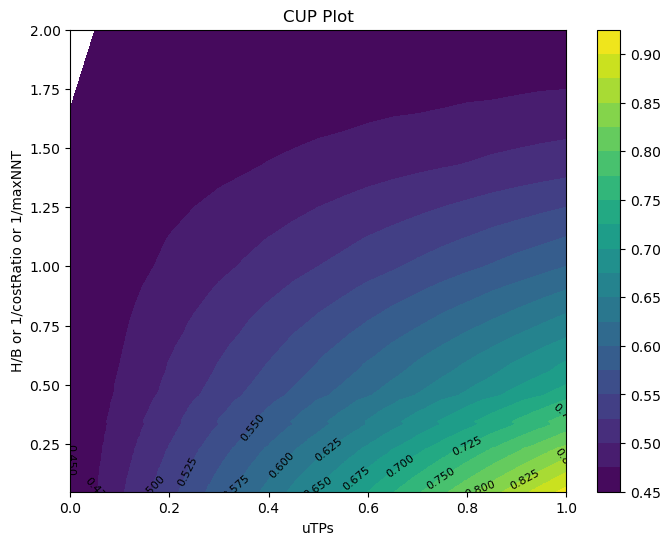

In [84]:
# Now we create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X.T, (1/Y).T, Z, 20, cmap='viridis')  # Using contourf for filled contours
plt.colorbar(contour)
plt.clabel(contour, inline=False, fontsize=8, colors = 'black')
plt.xlabel('uTPs')
plt.ylabel('H/B or 1/costRatio or 1/maxNNT')
plt.title('CUP Plot')
plt.show()

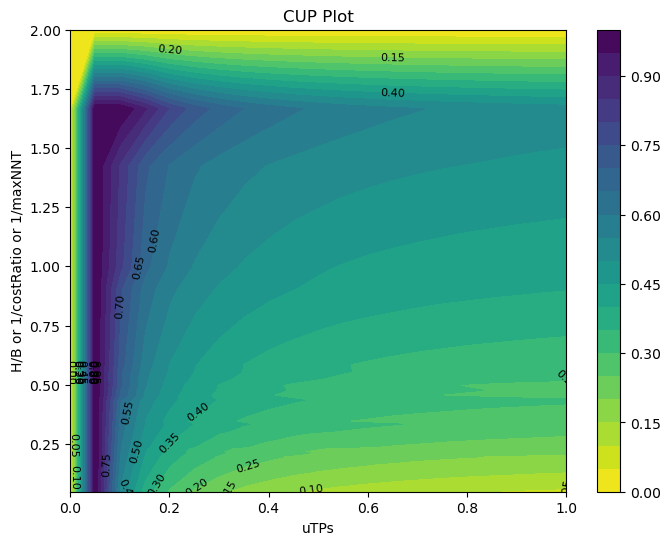

In [87]:
# Now we create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X.T, (1/Y).T, Z1, 20, cmap='viridis_r')  # Using contourf for filled contours
plt.colorbar(contour)
plt.clabel(contour, inline=False, fontsize=8, colors = 'black')
plt.xlabel('uTPs')
plt.ylabel('H/B or 1/costRatio or 1/maxNNT')
plt.title('CUP Plot')
plt.show()

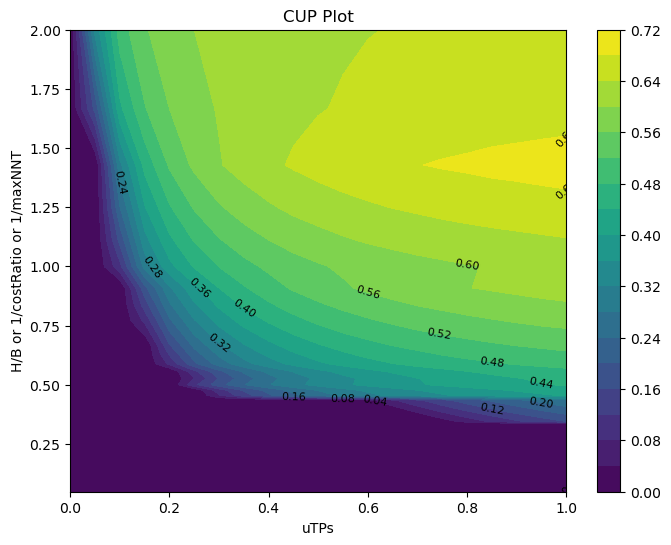

In [86]:
# Now we create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, (1/Y), Z2.T, 20, cmap='viridis')  # Using contourf for filled contours
plt.colorbar(contour)
plt.clabel(contour, inline=False, fontsize=8, colors = 'black')
plt.xlabel('uTPs')
plt.ylabel('H/B or 1/costRatio or 1/maxNNT')
plt.title('CUP Plot')
plt.show()

In [63]:
1 - (0.9 - 0) * 0.244

0.7804

In [64]:
0.244 * (1 - pDisease) / pDisease

0.244

In [78]:
pLpUThresholds(0.97, 0.1, 1, 0.9, 0, 0.7804, -0.05)


[0.2313009041321079, 0]

cutoff

pU
- many desired slopes share the same actual point.
- 